## Скачивание данных для тренировки модели

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/data/Diploma\ ML-mid/train.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/uncertain/1832.jpg  
  inflating: train/uncertain/1833.jpg  
  inflating: train/uncertain/1834.jpg  
  inflating: train/uncertain/1835.jpg  
  inflating: train/uncertain/1836.jpg  
  inflating: train/uncertain/1837.jpg  
  inflating: train/uncertain/1838.jpg  
  inflating: train/uncertain/1839.jpg  
  inflating: train/uncertain/184.jpg  
  inflating: train/uncertain/1840.jpg  
  inflating: train/uncertain/1841.jpg  
  inflating: train/uncertain/1842.jpg  
  inflating: train/uncertain/1843.jpg  
  inflating: train/uncertain/1844.jpg  
  inflating: train/uncertain/1845.jpg  
  inflating: train/uncertain/1846.jpg  
  inflating: train/uncertain/1847.jpg  
  inflating: train/uncertain/1848.jpg  
  inflating: train/uncertain/1849.jpg  
  inflating: train/uncertain/185.jpg  
  inflating: train/uncertain/1850.jpg  
  inflating: train/uncertain/1851.jpg  
  inflating: train/uncertain/1852.jpg  
  inflating: t

## Подготовка тренировочной и валидационной выборок

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 100
IMG_SHAPE  = 128

dir = Path("train")

In [4]:
from tensorflow.keras.applications.resnet50 import preprocess_input
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input, # препроцессинг
                               validation_split=0.2, # размер валидационной выборки, так как всё берётся из одной папки
                               rotation_range=40,  # максимальный угол поворота
                               width_shift_range=0.2, # смещение максимум на 20% ширины по горизонтали
                               height_shift_range=0.2, # смещение максимум на 20% высоты по вертикали
                               zoom_range=0.2, # картинка будет увеличена или уменьшена не более чем на 20%
                               horizontal_flip=True, # случайное отражение по горизонтали
                               fill_mode="nearest") 

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode="categorical",
                                                     subset = "training")

val_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE),
                                                              class_mode='categorical',
                                                              subset = "validation")

Found 40039 images belonging to 9 classes.
Found 10007 images belonging to 9 classes.


## Импорт ResNet50 & fine-tuning

In [14]:
IMG_SHAPE = (128, 128, 3)

base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

base_model.trainable = True
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [15]:
from keras.optimizers import Adam,SGD,RMSprop
from keras.layers import Dense,Input,Dropout,AveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop

NUM_CLASSES = 9

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.AveragePooling2D(pool_size=(4, 4)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(NUM_CLASSES)
])

In [16]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
average_pooling2d_6 (Average (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 9)                 2313      
Total params: 24,114,569
Trainable params: 24,061,449
Non-trainable params: 53,120
_____________________________________

In [17]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-5), # уменьшили скорость обучения
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
average_pooling2d_6 (Average (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 9)                 2313      
Total params: 24,114,569
Trainable params: 24,061,449
Non-trainable params: 53,120
_____________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

## Обучение и сохранение модели

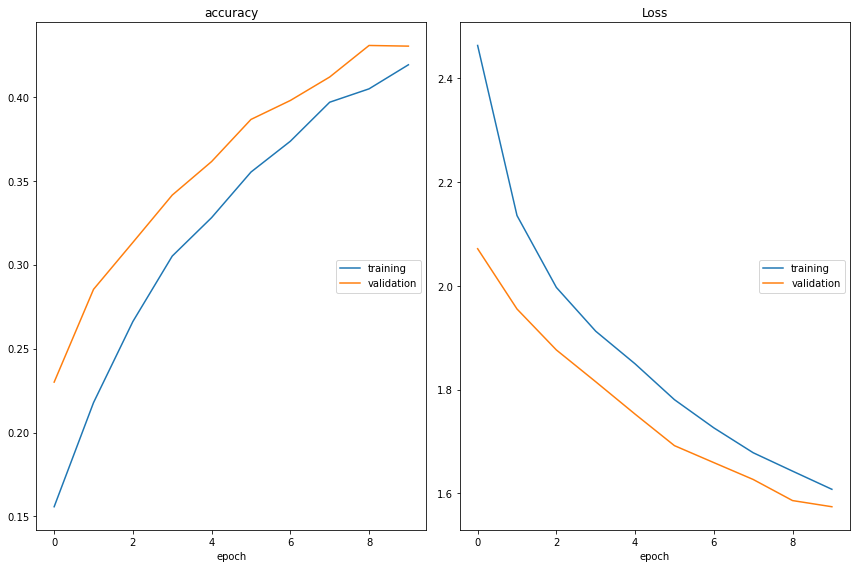

accuracy
	training         	 (min:    0.156, max:    0.419, cur:    0.419)
	validation       	 (min:    0.230, max:    0.431, cur:    0.430)
Loss
	training         	 (min:    1.608, max:    2.463, cur:    1.608)
	validation       	 (min:    1.574, max:    2.072, cur:    1.574)


In [19]:
EPOCHS = 10
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

In [20]:
model.save("/content/gdrive/MyDrive/models/Diploma ML-mid (default)/resnet50/10ep")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/models/Diploma ML-mid (default)/resnet50/10ep/assets


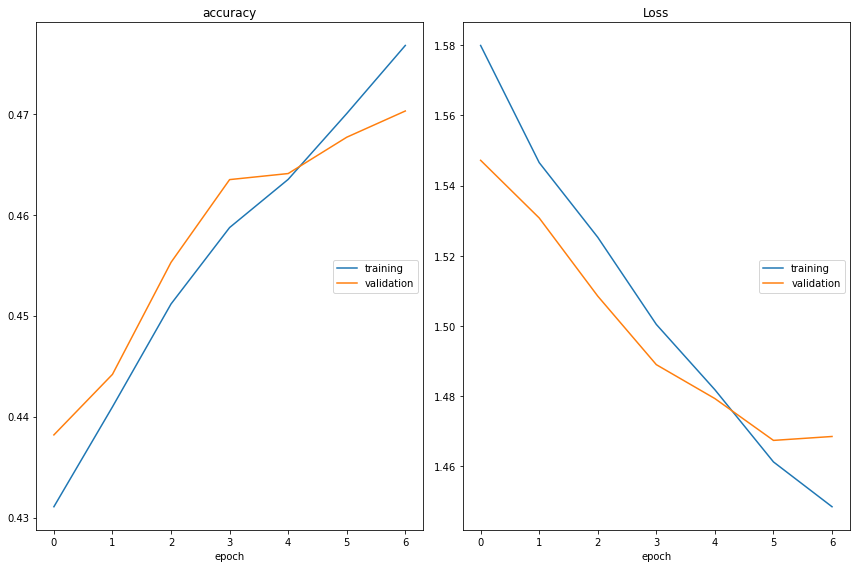

accuracy
	training         	 (min:    0.431, max:    0.477, cur:    0.477)
	validation       	 (min:    0.438, max:    0.470, cur:    0.470)
Loss
	training         	 (min:    1.449, max:    1.580, cur:    1.449)
	validation       	 (min:    1.467, max:    1.547, cur:    1.469)


In [21]:
EPOCHS = 7
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

In [22]:
model.save("/content/gdrive/MyDrive/models/Diploma ML-mid (default)/resnet50/17ep")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/models/Diploma ML-mid (default)/resnet50/17ep/assets


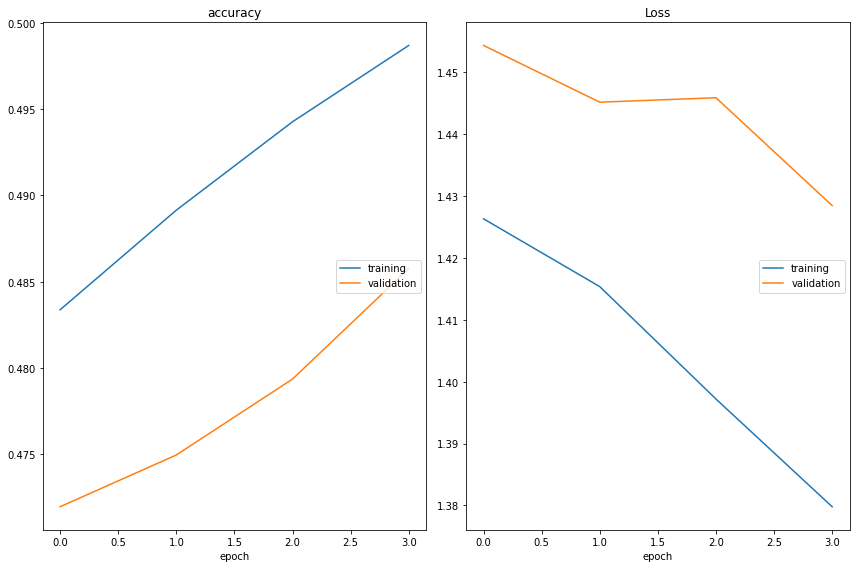

accuracy
	training         	 (min:    0.483, max:    0.499, cur:    0.499)
	validation       	 (min:    0.472, max:    0.486, cur:    0.486)
Loss
	training         	 (min:    1.380, max:    1.426, cur:    1.380)
	validation       	 (min:    1.428, max:    1.454, cur:    1.428)


In [23]:
EPOCHS = 4
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

## Проверка времени инференса модели

In [ ]:

import numpy as np
import cv2
from imageio import imread

data = np.empty((1, 256, 256, 3))

image = cv2.imread("/content/gdrive/MyDrive/data/Diploma ML-mid/test_kaggle/4914.jpg")
image = cv2.resize(image, (256, 256))
data[0] = image
data = preprocess_input(data)

In [ ]:
%%timeit -n 10 -r 10

predictions = model.predict(data)

10 loops, best of 10: 45.9 ms per loop


In [ ]:
np.argmax(predictions)

4